In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))

# Dallas

https://www.dallasopendata.com/Public-Safety/Police-Incidents/tbnj-w5hb

Quickly show what our library loads.  See the notebook `Dallas Explore Data` for more details.

We load all the data and try to join records to extract the maximum amount of information.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import numpy as np
import opencrimedata.dallas as dallas
import os, lzma, collections, datetime
import pyproj
import tilemapbase

In [3]:
#datadir = os.path.join("/media", "disk", "Data")
datadir = os.path.join("..", "..", "..", "..", "Data")
#filename = os.path.join(datadir, "Dallas_11_Sept_2017.csv.xz")
filename = os.path.join(datadir, "Dallas_7_Dec_2017.csv.xz")
def gen():
    with lzma.open(filename, "rt") as f:
        yield from dallas.load_full(f)

In [4]:
next(gen())

Row(code='276285-2016', crime_type='BURGLARY', crime_subtype='BURGLARY-RESIDENCE', start_time=datetime.datetime(2016, 11, 16, 11, 0), end_time=datetime.datetime(2016, 11, 18, 11, 0), call_time=datetime.datetime(2016, 11, 18, 11, 42, 26), address='5850 BELT LINE RD', city='DALLAS 75254', lonlat=(-96.807131, 32.953948), xy=(758206.7262484236, 2144003.9338816064))

## Crime types

In [5]:
crime_types = collections.defaultdict(set)
for row in gen():
    crime_types[row.crime_type].add(row.crime_subtype)

In [6]:
crime_types

defaultdict(set,
            {'': {''},
             "'FRAUD": {'FRAUD'},
             'ACCIDENTAL INJURY': {'INJURED PUBLIC'},
             'AGGRAVATED ASSAULT': {'AGG ASSAULT - NFV'},
             'AIRPLANE': {'OTHERS'},
             'ANIMAL BITE': {'ANIMAL BITE'},
             'ARSON': {'ARSON'},
             'ASSAULT': {'ASSAULT'},
             'AUTO THEFT - UUMV': {'UUMV'},
             'BURGLARY': {'BURGLARY-BUSINESS', 'BURGLARY-RESIDENCE'},
             'CHILD (OFFENSES AGAINST)': {'OFFENSE AGAINST CHILD'},
             'CRIMINAL MISCHIEF/VANDALISM': {'CRIMINAL MISCHIEF/VANDALI',
              'LANDALISM & CRIM MISCHIEF',
              'VANDALISM & CRIM MISCHIEF'},
             'DISORDERLY CONDUCT': {'DISORDERLY CONDUCT'},
             'DWI': {'DWI'},
             'EMBEZZLEMENT': {'EMBEZZLEMENT'},
             'FIREARMS ACCIDENT': {'INJURED FIREARM'},
             'FORGERY & COUNTERFEIT': {'FORGE & COUNTERFEIT'},
             'FOUND PROPERTY': {'FOUND'},
             'FRAUD': {'

# Timestamps

In [7]:
times = [ (row.start_time, row.end_time, row.call_time) for row in gen() ]
len(times)

301526

In [8]:
no_data_count = sum(st==None or en==None or call==None for st, en, call in times)
no_data_count

534

In [9]:
times = [row for row in times if not any(x is None for x in row)]
len(times)

300992

In [10]:
out_of_order_count = sum(st > en for st, en, _ in times)
out_of_order_count

9

In [11]:
times = [row for row in times if row[0] <= row[1]]
len(times)

300983

In [12]:
print("% of start==end cases:", sum(st==en for st,en,_ in times) / len(times) * 100)
print("% of cases of 5 minute or less gap:",
      sum(en - st < datetime.timedelta(minutes=5) for st,en,_ in times) / len(times) * 100)

% of start==end cases: 21.831797809178592
% of cases of 5 minute or less gap: 29.428904622520207


7.3572222674
6.77491202924
6.20647482335


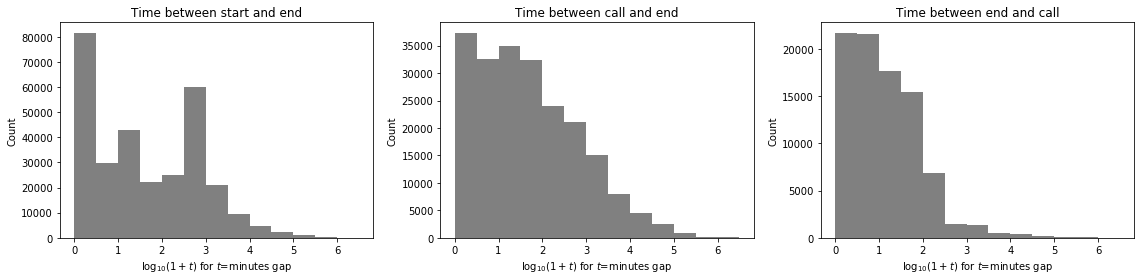

In [13]:
lengths = np.asarray([(en-st).total_seconds()/60 for st,en,_ in times])
call_diffs = np.asarray([(call-en).total_seconds()/60 for st,en,call in times])

fig, axes = plt.subplots(ncols=3, figsize=(16,4))

ax = axes[0]
log_lens = np.log10(1 + lengths)
print(np.max(log_lens))
ax.hist(log_lens, color="grey", bins=list(x/2 for x in range(14)))
ax.set(xlabel="$\log_{10}(1+t)$ for $t$=minutes gap")
ax.set(ylabel="Count")
ax.set(title="Time between start and end")

ax = axes[1]
cc = [x for x in call_diffs if x>=0]
cc = np.log10(1 + np.asarray(cc))
print(np.max(cc))
ax.hist(cc, color="grey", bins=list(x/2 for x in range(14)))
ax.set(xlabel="$\log_{10}(1+t)$ for $t$=minutes gap")
ax.set(ylabel="Count")
ax.set(title="Time between call and end")

ax = axes[2]
cc = [-x for x in call_diffs if x<0]
cc = np.log10(1 + np.asarray(cc))
print(np.max(cc))
ax.hist(cc, color="grey", bins=list(x/2 for x in range(14)))
ax.set(xlabel="$\log_{10}(1+t)$ for $t$=minutes gap")
ax.set(ylabel="Count")
ax.set(title="Time between end and call")

fig.tight_layout()

In [14]:
fig.savefig("dallas_times.pdf")

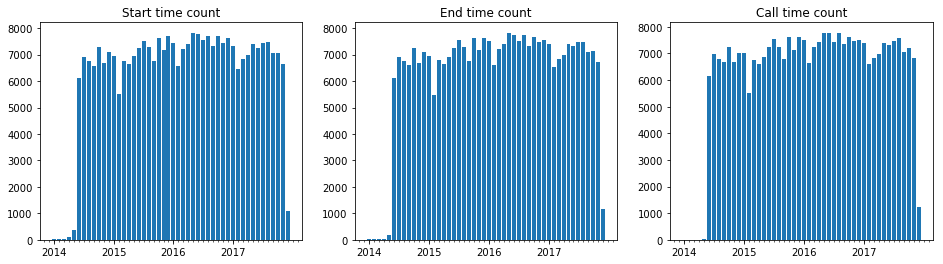

In [15]:
def plot_times(ax, times):
    counts = []
    for m in range(12 * 4):
        y = m // 12
        start = datetime.datetime(2014+y, 1 + (m%12), 1)
        y = (m+1) // 12
        end = datetime.datetime(2014+y, 1 + ((m+1)%12), 1)
        counts.append( sum(start <= st and st < end for st in times) )

    ax.bar(list(range(12*4)), counts)
    ax.set_xticks([0,12,24,36])
    ax.set_xticklabels([str(x) for x in range(2014,2018)])
    ml = matplotlib.ticker.MultipleLocator(1)
    ax.xaxis.set_minor_locator(ml)

fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for i, ax in enumerate(axes):
    plot_times(ax, [x[i] for x in times])
    
axes[0].set_title("Start time count")
axes[1].set_title("End time count")
axes[2].set_title("Call time count")

## Address data

In [16]:
adds = [(row.address, row.city) for row in gen()]

In [17]:
sum(city=="" for ad, city in adds)

1773

In [18]:
sum(ad=="" for ad, city in adds)

1761

In [19]:
sum(city=="" or ad=="" for ad, city in adds)

1774

## Locations

In [20]:
no_latlon_times = []
latlon_times = []
for row in gen():
    if row.call_time is None:
        continue
    if row.lonlat is None:
        no_latlon_times.append(row.call_time)
    else:
        latlon_times.append(row.call_time)

In [21]:
# This is almost useless.  Make a plot like above, per month, but with stacked bars
max(latlon_times), min(no_latlon_times)

(datetime.datetime(2017, 2, 7, 23, 18, 50),
 datetime.datetime(2014, 5, 29, 15, 59, 45))

In [22]:
len(no_latlon_times), len(latlon_times)

(179613, 121382)

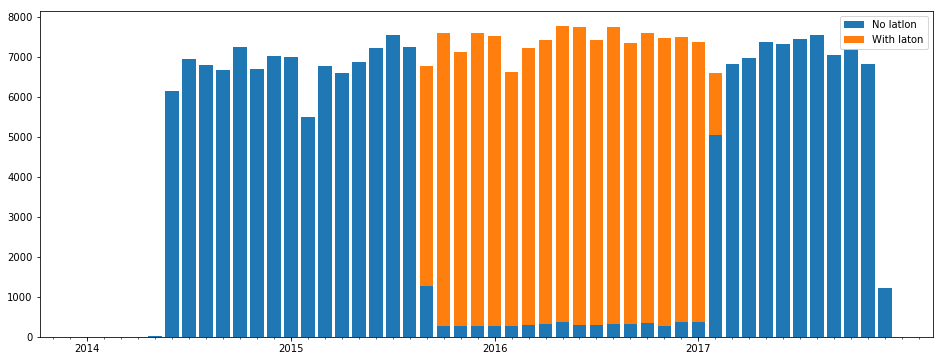

In [23]:
fig, ax = plt.subplots(figsize=(16,6))

counts, counts1 = [], []
for m in range(12 * 4):
    y = m // 12
    start = datetime.datetime(2014+y, 1 + (m%12), 1)
    y = (m+1) // 12
    end = datetime.datetime(2014+y, 1 + ((m+1)%12), 1)
    counts.append( sum(start <= st and st < end for st in no_latlon_times) )
    counts1.append( sum(start <= st and st < end for st in latlon_times) )

ax.bar(list(range(12*4)), counts, label="No latlon")
ax.bar(list(range(12*4)), counts1, bottom=counts, label="With laton")
ax.set_xticks([0,12,24,36])
ax.set_xticklabels([str(x) for x in range(2014,2018)])
ml = matplotlib.ticker.MultipleLocator(1)
ax.xaxis.set_minor_locator(ml)
ax.legend()
None

In [24]:
sum(row.xy is None for row in gen())

8125

# Plots of differences

In [25]:
proj = pyproj.Proj({"init":"EPSG:2845"})

lonlat, xy = [], []
for row in gen():
    if row.lonlat is None or row.xy is None:
        continue
    xx, yy = proj(*row.xy, inverse=True)
    lonlat.append(tilemapbase.project(*row.lonlat))
    xy.append(tilemapbase.project(xx,yy))
lonlat = np.asarray(lonlat)
xy = np.asarray(xy)

lines = [[s,e] for s,e in zip(lonlat, xy)]

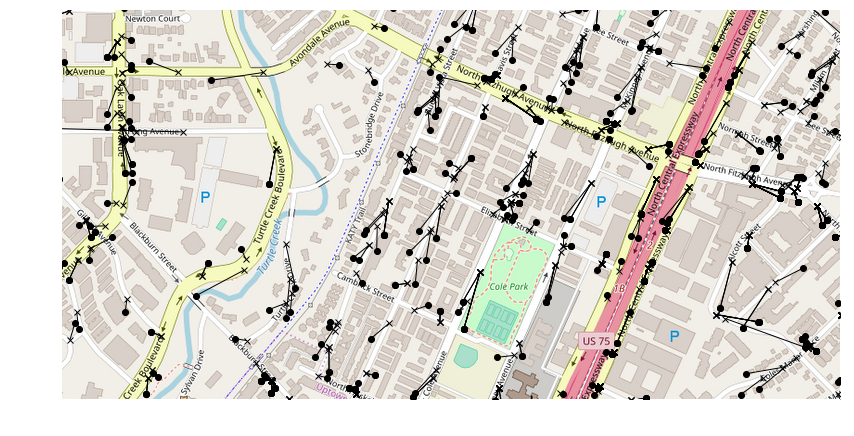

In [26]:
ex = tilemapbase.Extent.from_centre_lonlat(-96.7947, 32.8148, xsize=0.00005, aspect=2)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)

fig, ax = plt.subplots(figsize=(12,10))
plotter.plot(ax)
ax.set_axis_off()

ax.scatter(*lonlat.T, marker="x", color="black", linewidth=1)
ax.scatter(*xy.T, marker="o", color="black", linewidth=1)
c = matplotlib.collections.LineCollection(lines, linewidth=1, color="black")
ax.add_collection(c)

fig.tight_layout()

In [27]:
fig.savefig("dallas_geocoding_1.png", dpi=100)

In [28]:
lonlat, xy = [], []
for row in gen():
    if row.lonlat is None or row.xy is None:
        continue
    lonlat.append(row.lonlat)
    xy.append(row.xy)
lonlat = proj(*np.asarray(lonlat).T)
xy = np.asarray(xy)
lonlat = np.asarray(lonlat).T

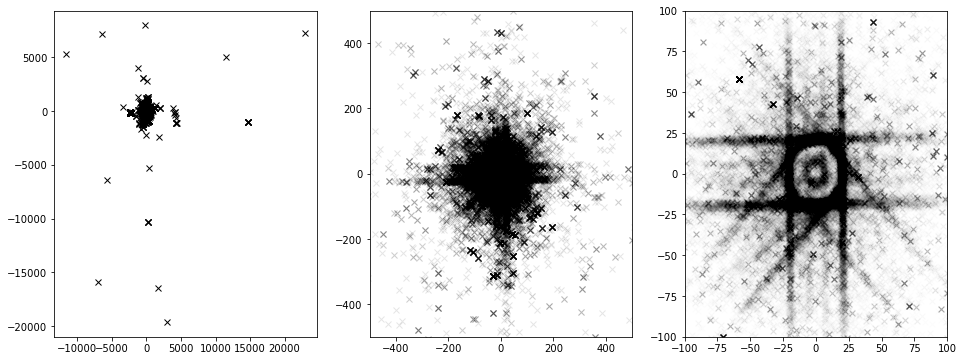

In [29]:
fig, axes = plt.subplots(ncols=3, figsize=(16,6))
axes[0].scatter(*(xy - lonlat).T, marker="x", color="black", linewidth=1)
axes[1].scatter(*(xy - lonlat).T, marker="x", color="black", linewidth=1, alpha=0.1)
axes[1].set(xlim=[-500,500], ylim=[-500,500])
axes[2].scatter(*(xy - lonlat).T, marker="x", color="black", linewidth=1, alpha=0.01)
axes[2].set(xlim=[-100,100], ylim=[-100,100])
None

In [30]:
dists = np.sqrt(np.sum((xy-lonlat)**2, axis=1))
dists = np.sort(dists)

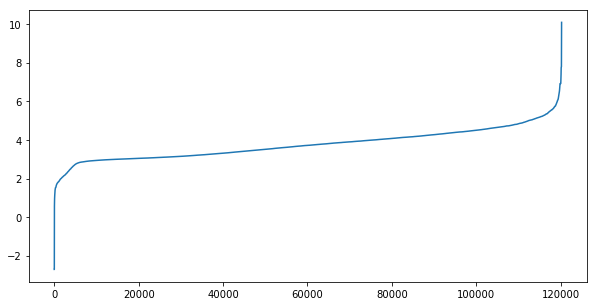

In [31]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(np.log(dists))
None